In [1]:
from transformers import BigBirdForSequenceClassification, BigBirdTokenizer
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt

# specify GPU
device = torch.device("cuda")


tokenizer = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')
model = BigBirdForSequenceClassification.from_pretrained('google/bigbird-roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/846k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
df = pd.read_csv("/content/dataset_train_updated.csv")
print(df.head())
texts = df['text'].tolist()
labels = df['class'].tolist()
import pandas as pd
import torch

# Load the test dataset
test_df = pd.read_csv("/content/dataset_test_updated.csv")

# Extract text and labels
test_texts = test_df['text'].tolist()
test_labels = test_df['class'].tolist()


                                                text  class
0    this boy is getting cookies outof this jar ....      0
1   well for one thing this boy's on the stool ge...      1
2   oh yes .  well the mother is washing the dish...      1
3   action ? what's going on in the picture ? the...      0
4   the little boy is getting a cookie out of the...      1


In [3]:
df['class'].value_counts(normalize = True)

,proportion
class,
0,0.51005
1,0.48995


In [4]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=.1)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
# Tokenize the test dataset
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
# Convert labels to tensors
test_labels = torch.tensor(test_labels)

# Test encodings and labels are ready for evaluation
print("Test data tokenized and labels converted to tensors.")

Test data tokenized and labels converted to tensors.


In [5]:
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW

class TextClassificationDS(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

train_dataset = TextClassificationDS(train_encodings, train_labels)
val_dataset = TextClassificationDS(val_encodings, val_labels)
test_dataset = TextClassificationDS(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training label distribution: Counter({tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(1):

<ipython-input-5-7490062dc11b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Epoch,Training Loss,Validation Loss
1,0.045100,1.105001
2,0.341300,0.758109
3,0.049600,1.660746
4,0.126800,0.503305
5,0.011900,0.866483
6,0.001000,1.096328
7,0.065100,0.833204


<ipython-input-5-7490062dc11b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
<ipython-input-5-7490062dc11b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
<ipython-input-5-7490062dc11b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
<ipython-input-5-7490062dc11b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

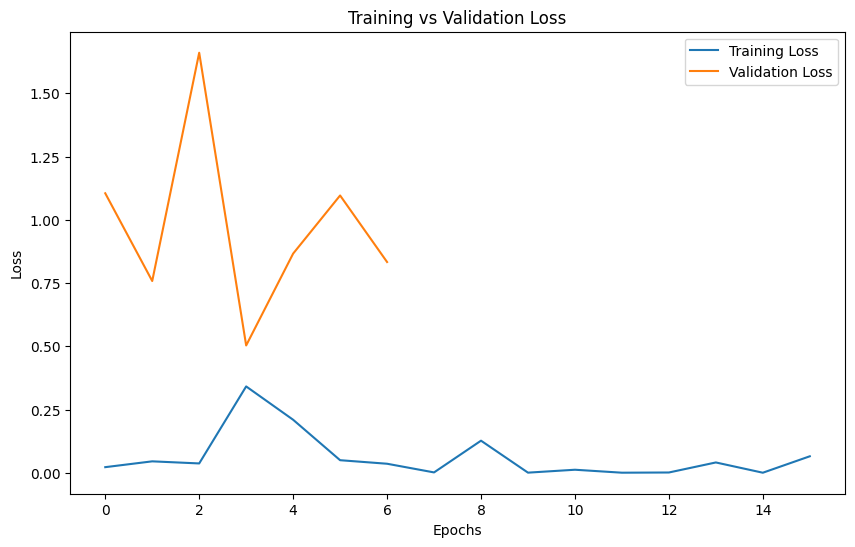

In [9]:
from transformers import Trainer, TrainingArguments, EvalPrediction, EarlyStoppingCallback
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import Counter

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=30,
    learning_rate=5e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    logging_dir='./logs',
    save_strategy="epoch",
    save_total_limit=2,
    logging_steps=10,                # Log every 10 steps to get frequent logs
    load_best_model_at_end=True,     # Load the best model when finished training
    metric_for_best_model="eval_loss",  # Use validation loss to track the best model
    greater_is_better=False,         # Since we're tracking loss, lower is better
)

# Check data balance
train_label_counts = Counter(train_dataset.labels)
print(f"Training label distribution: {train_label_counts}")

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Early stopping with patience of 3 epochs
)

# Train the model and collect logs for training and validation loss
train_output = trainer.train()

# Extract loss values
training_logs = trainer.state.log_history
train_loss = []
val_loss = []

# Collect training and validation losses from logs
for log in training_logs:
    if 'loss' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        val_loss.append(log['eval_loss'])

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


<ipython-input-5-7490062dc11b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


<ipython-input-5-7490062dc11b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Sample logits: [[ 3.6763232 -3.864976 ]
 [ 3.1142688 -3.2616186]
 [ 4.358004  -4.595211 ]
 [-4.2336035  4.1814976]
 [-4.17553    4.172118 ]
 [-4.197006   4.1858177]
 [ 4.062522  -4.2677145]
 [-4.156922   4.0786834]
 [ 2.9118953 -3.061617 ]
 [ 4.305532  -4.548642 ]]
Test Accuracy: 0.8700
Test Precision: 0.8148
Test Recall: 0.9362
Test F1 Score: 0.8713


<Figure size 800x600 with 0 Axes>

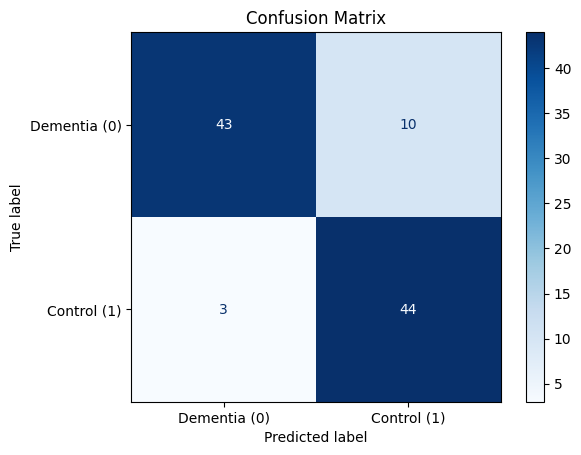

In [13]:

test_results = trainer.evaluate(test_dataset)
# Compute additional metrics on the test dataset
test_predictions = trainer.predict(test_dataset).predictions
test_preds = torch.argmax(torch.tensor(test_predictions), dim=-1).numpy()

# Calculate metrics
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='binary', pos_label=1)
recall = recall_score(test_labels, test_preds, average='binary', pos_label=1)
f1 = f1_score(test_labels, test_preds, average='binary', pos_label=1)
conf_matrix = confusion_matrix(test_labels, test_preds, labels=[0, 1])

# Check logits to verify predictions are balanced
test_logits = trainer.predict(test_dataset).predictions
print("Sample logits:", test_logits[:10])

# Display results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Dementia (0)", "Control (1)"])
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()
